In [1]:
import os
import glob
import sys
import getpass
import importlib
from tqdm import tqdm
from pathlib import Path

# user path:
usrname = getpass.getuser()
# add paths:
sys.path.append(f'/Users/{usrname}/Desktop/Projects')
sys.path.append(f'/Users/{usrname}/Desktop/Projects/bimanual_wrist')
sys.path.append(f'/Users/{usrname}/Desktop/Projects/Functional_Fusion')
sys.path.append(f'/Users/{usrname}/Desktop/Projects/PcmPy')


import rsatoolbox as rsa
from rsatoolbox.io import spm as spm_io
import surfAnalysisPy as surf
import SUITPy as suit
import nibabel as nb
import nitools as nt
import PcmPy as pcm
import Functional_Fusion.atlas_map as am
import Functional_Fusion.reliability as rel

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.cm import ScalarMappable
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.patches as patches
import seaborn as sns

import scipy.stats as stats
import scipy
import scipy.io as sio
import numpy as np
import pandas as pd

import utils
importlib.reload(utils)

# SET PATHS:
baseDir = os.path.join('/Users', getpass.getuser(), 'Desktop', 'Projects', 'bimanual_wrist', 'data', 'fMRI')
bidsDir = 'BIDS'
anatomicalDir = 'anatomicals'
freesurferDir = 'surfaceFreesurfer'
surfacewbDir = 'surfaceWB' 
behavDir = 'behavioural'
regDir = 'ROI'
atlasDir = '/Volumes/diedrichsen_data$/data/Atlas_templates/fs_LR_32'
analysisDir = os.path.join(os.path.dirname(os.path.dirname(baseDir)), 'analysis')



# Build datast

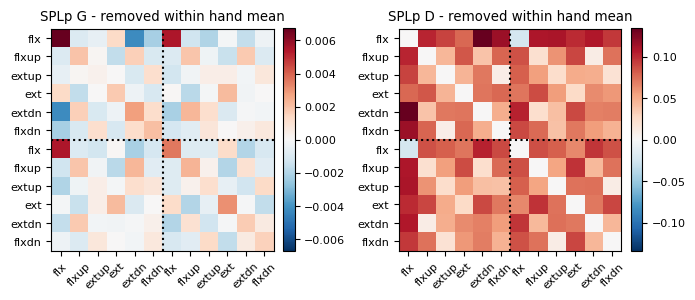

In [184]:
labels = ['flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn', 'flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn']
labels_lateral = ['contra']*6 + ['ipsi']*6
cmap = 'RdBu_r'
sn_bad = [102, 103]
regions = ['M1','S1','PMd','PMv','SMA','SPLa','SPLp','V1']
hem = ['L','R']

region = regions[6]
data, cond_vec, part_vec = [], [], []
for i_hem, h in enumerate(hem):
    roi = f'{region}_{h}'
    file_path = os.path.join(analysisDir, f'pwbeta_{roi}.npz')
    d = np.load(file_path, allow_pickle=True)

    subject = d['subject']
    indices = [k for k, s in enumerate(subject) if s not in sn_bad]

    subject = d['subject'][indices]
    cond_name_tmp = d['cond_intrinsic_vec'][indices]
    cond_vec_tmp = d['cond_num_vec'][indices]
    data_tmp = d['beta_white'][indices]
    part_tmp = d['part_vec'][indices]

    for i_sub in range(len(subject)):
        idx1 = [j for j, c in enumerate(cond_name_tmp[i_sub]) if 'rhand' in c]
        idx2 = [j for j, c in enumerate(cond_name_tmp[i_sub]) if 'lhand' in c]
        idx = idx1 + idx2
        # Y = data_tmp[i_sub][idx, :]
        Y1 = data_tmp[i_sub][idx1, :]
        Y2 = data_tmp[i_sub][idx2, :]

        # remove mean of voxels across conditions of rhand:
        rhand_parts = part_tmp[i_sub][idx1]
        for p in np.unique(rhand_parts):
            Y1[rhand_parts == p, :] = Y1[rhand_parts == p, :] - np.mean(Y1[rhand_parts == p, :], axis=0)
        # remove mean of voxels across conditions of lhand:
        lhand_parts = part_tmp[i_sub][idx2]
        for p in np.unique(lhand_parts):
            Y2[lhand_parts == p, :] = Y2[lhand_parts == p, :] - np.mean(Y2[lhand_parts == p, :], axis=0)
        Y = np.vstack((Y1, Y2))

        subj_part = part_tmp[i_sub][idx]
        # Sort the conditions so that contralateral condition comes first.
        # Also, within hand order is flx, flxup, extup, ext, extdn, flxdn.
        # refer to notebooks_mri/extract_data.ipynb to understand exactly why this works:
        if h == 'L':
            subj_cond = cond_vec_tmp[i_sub][idx]
            tmp = subj_cond.copy()
            subj_cond[tmp > 5] = tmp[tmp > 5] - 6
            subj_cond[tmp <= 5] = tmp[tmp <= 5] + 6 
        elif h == 'R':
            subj_cond = cond_vec_tmp[i_sub][idx]

        data.append(Y)
        cond_vec.append(np.array(subj_cond))
        part_vec.append(subj_part)

Y = []
# --- RDM Calculation ---
for i_sub in range(len(data)):
    obs_des = {'cond_vec': cond_vec[i_sub], 'part_vec': part_vec[i_sub]}
    Y.append(pcm.dataset.Dataset(data[i_sub], obs_descriptors=obs_des))

N = len(Y)
ncond = len(np.unique(Y[0].obs_descriptors['cond_vec']))
G_hat = np.zeros((N, ncond, ncond))
for i_sub in range(N):
    G_hat[i_sub, :, :], _ = pcm.est_G_crossval(Y[i_sub].measurements,
                                                Y[i_sub].obs_descriptors['cond_vec'],
                                                Y[i_sub].obs_descriptors['part_vec'],
                                                X=pcm.matrix.indicator(Y[i_sub].obs_descriptors['part_vec']))

# avg G:
fig, ax = plt.subplots(1,2,figsize=(7,3))
G_hat_avg = np.mean(G_hat, axis=0)
vmax_avg = np.abs(G_hat_avg).max()
ax[0].imshow(G_hat_avg, vmin=-vmax_avg, vmax=vmax_avg, cmap=cmap)
sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=-vmax_avg, vmax=vmax_avg))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax[0], fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=8)
ax[0].set_title(f'{region} G - removed within hand mean')
# add lines to separate hands:
ax[0].axhline(5.5, color='k', linestyle=':', linewidth=1.5)
ax[0].axvline(5.5, color='k', linestyle=':', linewidth=1.5)
ax[0].set_xticks(np.arange(ncond))
ax[0].set_yticks(np.arange(ncond))
ax[0].set_xticklabels(labels, fontsize=8, rotation=45)
ax[0].set_yticklabels(labels, fontsize=8)

# avg D:
D_hat_avg = pcm.G_to_dist(G_hat_avg)
D_hat_avg = np.sign(D_hat_avg) * np.sqrt(np.abs(D_hat_avg))
vmax = np.abs(D_hat_avg).max()
ax[1].imshow(D_hat_avg, vmin=-vmax, vmax=vmax, cmap=cmap)
sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=-vmax, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax[1], fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=8)
ax[1].set_title(f'{region} D - removed within hand mean')
# add lines to separate hands:
ax[1].axhline(5.5, color='k', linestyle=':', linewidth=1.5)
ax[1].axvline(5.5, color='k', linestyle=':', linewidth=1.5)
ax[1].set_xticks(np.arange(ncond))
ax[1].set_yticks(np.arange(ncond))
ax[1].set_xticklabels(labels, fontsize=8, rotation=45)
ax[1].set_yticklabels(labels, fontsize=8)
plt.tight_layout()
plt.show()



# What is the relationship between contra and ipsi structures after removing their mean differences?

Here I removed the translation between ipsi and contra by placing both around 0. If the two representations (think of them as point clouds of conditions) are completely parallel (0 rotation), the covariance of contra with ipsi will exactly mimic the within-hand covariance structure. On the other hand, if contra and ipsi are orthogonal, their covariance will be 0 after translating them to the same center. One simple test is to look at the diagonal of the top right (or bottom left) square of the RDM. If the diagonal elements are near 0, it points to a parallel arrangement. However, if they are systematically away from 0, it suggests a less parallel or more orthogonal arrangement. 

But the previous test might just give us a very approximate idea on how the ispi and contra point clouds are rotated with respect to each other. If the distances are 0, I think we can confidently say that the two point cloud are parallel and lie within the same subspace. However, if the distances are not 0, we need to dig more. For example, an orthogonal rotation can make the distances non-zero. But even a within-plane rotation can do the same thing. So we need a way to differentiate between the two. Let's look at the distance of the intrinsicly equal conditions, extrinsicly equal conditions and unrelated conditinos.

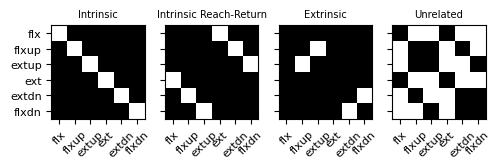

/var/folders/sc/kmc7_9gn2hqd_lrnhdt_2s580000gn/T/ipykernel_67300/611459076.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), ha='right', rotation=45)


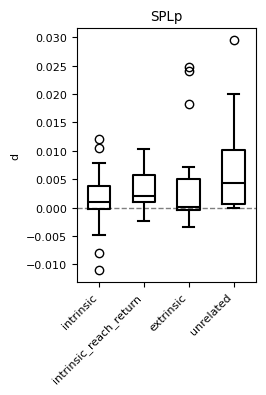

SPLp
TEST: Mean of intrinsic distances > 0
    t(23): 1.2250, p-value: 0.1165
TEST: Mean of intrinsic_reach_return distances > 0
    t(23): 4.4632, p-value: 0.0001
TEST: Mean of extrinsic distances > 0
    t(23): 2.2427, p-value: 0.0174
TEST: Mean of unrelated distances > 0
    t(23): 4.2671, p-value: 0.0001


In [185]:
mask_intrinsic = np.eye(6) # picking the same exact intrinsic conditions: e.g., flx:flx, flxup:flxup, ...
mask_intrinsic_reach_return = np.tile(np.eye(3), (2,2)) - np.eye(6) # picking the conditoins that were involved in the same reach-return movement: e.g., flx:ext, flxup:extdn, ...

mask_extrinsic = np.zeros((6,6)) # picking the extrinsicly similar conditions (moving to the same direction in space): e.g., flxup:extup, extdn:flxdn, ...
mask_extrinsic[1,2] = 1
mask_extrinsic[2,1] = 1
mask_extrinsic[4,5] = 1
mask_extrinsic[5,4] = 1

mask_unrelated = np.ones((6,6)) - mask_intrinsic - mask_intrinsic_reach_return - mask_extrinsic # picking the unrelated conditions: e.g., flx:extup, flx:extdn, flxup:flxdn, ...

# visualize masks:
plt.rcParams.update({'font.size': 6})
fig, ax = plt.subplots(1,4,figsize=(5,3), sharex=True, sharey=True)
for i, m in enumerate([mask_intrinsic, mask_intrinsic_reach_return, mask_extrinsic, mask_unrelated]):
    ax[i].imshow(m, cmap='gray', vmin=0, vmax=1)
    ax[i].set_xticks(np.arange(6))
    ax[i].set_yticks(np.arange(6))
    ax[i].set_xticklabels(labels[:6], fontsize=8, rotation=45)
    ax[i].set_yticklabels(labels[:6], fontsize=8)
    if i == 0:
        ax[i].set_title('Intrinsic')
    elif i == 1:
        ax[i].set_title('Intrinsic Reach-Return')
    elif i == 2:
        ax[i].set_title('Extrinsic')
    elif i == 3:
        ax[i].set_title('Unrelated')
plt.tight_layout()
plt.show()


N = len(Y)
dist = {'type': [], 'd': []}
for i_sub in range(N):
    Di = pcm.G_to_dist(G_hat[i_sub,:,:])
    Di_between = Di[0:6, 6:12]
    Di_within = Di[0:6, 0:6]/2 + Di[6:12, 6:12]/2

    # intrinsic:
    d = Di_between * mask_intrinsic
    dist['type'].append('intrinsic')
    dist['d'].append(np.mean(d[d != 0]))


    # intrinsic reach-return:
    d = Di_between * mask_intrinsic_reach_return
    dist['type'].append('intrinsic_reach_return')
    dist['d'].append(np.mean(d[d != 0]))

    # extrinsic:
    d = Di_between * mask_extrinsic
    dist['type'].append('extrinsic')
    dist['d'].append(np.mean(d[d != 0]))

    # unrelated:
    d = Di_between * mask_unrelated
    dist['type'].append('unrelated')
    dist['d'].append(np.mean(d[d != 0]))

df = pd.DataFrame(dist)
plt.rcParams.update({'font.size': 8})
fig, ax = plt.subplots(1,1,figsize=(2.7,4))
sns.boxplot(data=df, x='type', y='d', width=0.5, fill=False, color='k', ax=ax)
# rotate xticks:
ax.set_xticklabels(ax.get_xticklabels(), ha='right', rotation=45)
ax.set_xlabel('')
ax.set_title(f'{region}')
ax.axhline(0, color='k', linestyle='--', linewidth=1, alpha=0.5)
plt.tight_layout()
plt.show()

# t-test within each type d>0:
print(f'{region}')
for t in df['type'].unique():
    d = df[df['type'] == t]['d']
    tstat, pval = stats.ttest_1samp(d, 0, alternative='greater')
    print(f'TEST: Mean of {t} distances > 0')
    print(f'    t({len(d)-1}): {tstat:.4f}, p-value: {pval:.4f}')


